# Webmining - Assignment 3

This **Home Assignment** is to be submitted and you will be given points for each of the tasks. You will familiarize yourself with the apriori algorithm, using stochastic gradient descend for matrix factorization and recommender systems using the surprise package. You can use numpy and all the python standard library for all tasks. You can then further use pandas for the first task and the surprise package for the last task.

## Formalities
**Submit in a group of 2-3 people until 30.06.2020 23:59CET. The deadline is strict!**

## Evaluation and Grading
General advice for programming excercises at *CSSH*:
Evaluation of your submission is done semi automatically. Think of it as this notebook being 
executed once. Afterwards, some test functions are appended to this file and executed respectively.

Therefore:
* Submit valid _Python3_ code only!
* Use external libraries only when specified by task.
* Ensure your definitions (functions, classes, methods, variables) follow the specification if
  given. The concrete signature of e.g. a function usually can be inferred from task description, 
  code skeletons and test cases.
* Ensure the notebook does not rely on current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
  * Double check if your code relies on presence of files or directories other than those mentioned
    in given tasks. Tests run under Linux, hence don't use Windows style paths 
    (`some\path`, `C:\another\path`). Also, use paths only that are relative to and within your
    working directory (OK: `some/path`, `./some/path`; NOT OK: `/home/alice/python`, 
    `../../python`).
* Keep your code idempotent! Running it or parts of it multiple times must not yield different
  results. Minimize usage of global variables.
* Ensure your code / notebook terminates in reasonable time.

**There's a story behind each of these points! Don't expect us to fix your stuff!**

Regarding the scores, you will get no points for a task if:
- your function throws an unexpected error (e.g. takes the wrong number of arguments)
- gets stuck in an infinite loop
- takes much much longer than expected (e.g. >1s to compute the mean of two numbers)
- does not produce the desired output (e.g. returns an descendingly sorted list even though we asked for ascending, returns the mean and the std even though we asked for only the mean, prints an output instead of returning it, ...)

# Task 1: Apriori (7 points)

In this task you should implement a general version of the apriori algorithm.

The main idea of the apriori principle/requirement is, that if a constraint $C$ (e.g. minimal support) does not hold for a pattern, it will never hold for any more specific pattern.
You encountered a version of the of the apriori principle defined on the **itemset** (mathematically it is a function defined on the powerset of the itemset set)

Example:
$$C( \{\text{apple}, \text{banana}\}) = 0 \Rightarrow C( \{\text{apple}, \text{banana}, \text{any_other_item}\}) = 0$$

One can also express this for constraints that are defined on **instance** sets: (mathematically the constrain is a function defined on the powerset of the instance set)
$$
C(X) = 0 \Rightarrow C(Y) = 0 \; \forall Y \subseteq X
$$
Hereby $X$ and $Y$ are instance sets!
We will write a general apriori algorithm that works with any constraint that satisfies this relationship. So our constraints are defined on the **instance** (power-)set. See the example below for how the support count is defined as a function of the itemset.



For this task a pattern will be a *sorted* tuple of items e.g. `('apple', 'banana', 'yoghurt')`. Items are just strings. Assume a constraint is a function that takes a dataframe and returns either True or False depending on whether the constraint is satisfied for that (subset) dataframe. A very popular of those constraints is the `min_support_count_constraint`
```python
from functools import partial
import numpy as np
import pandas as pd

def min_support_count_constraint_evaluator(df, min_support_count):
    return len(df) >= min_support_count

min_supp_100_constraint = partial(min_support_count_constraint_evaluator, min_support=100)

df_90 = pd.DataFrame.from_dict({"sth":np.random.rand(90)})# dataframe with 90 rows
print(min_supp_100_constraint(df_90)) # False

df_110 = pd.DataFrame.from_dict({"sth":np.random.rand(110)})# dataframe with 110 rows
print(min_supp_100_constraint(df_110)) # True
```

Assume the database is given as a dataframe each row representing a single transaction. It also has a column `'items'` that contains the items for that transaction as a set.
Represent association rules as tuple of two itemsets: e.g.
$$
(\text{apple}, \text{banana}) \Rightarrow (\text{yoghurt}, \text{milk})
$$
is represented as
```python
( ('apple', 'banana'), ('milk', 'yoghurt') )
```
Example database:
```python
db = pd.DataFrame.from_dict(
```
## a) Checking a constraint and pattern against a database (1.5)
Write a function `check_against_database(constraint, pattern, database)` that checks whether a single pattern holds given a specific pattern and the entire database. It returns either 0 (constraint does not hold) or True (constraint holds). Note that now the constraint has to be formulated as a function on the instance set, rather than on the itemsets.

## b) Generate next level candidates (1.5)

Write a function `generate_next_level_candidates(patterns)` that takes a list of patterns (assume that the constraint holds for all the patterns that are supplied). All the patterns are of the same length lets call it `l`. It `yield`s all patterns of length `l+1` that are not already excluded through the apriori principle. I.e. that for a pattern of length $l+1$ to be in the result **all** sub-patterns of length `l` are in `patterns`.

You will need an initial list of patterns that you then prune further. There are two ways of constructing these initial patterns:

*a)* The easy way is to collect all items that are in all the patterns and consider all combinations of those items of length $l+1$. It has runtime $O(I\, \text{over}\, (l+1))$. $x\, \text{over}\, y$ meaning the binomial coeff. $I$ is the number of items.

*b)* Usually you can gain significantly speedup in this step by only considering initial candidates of length $l+1$ that arise when matching pairs of patterns where the first $l-1$ patterns are the same. It has naive runtime of $O(\text{len}(\text{patterns})^2)$ but average case can go below it with a better implementation.

Implementing **one** of the strategies **is enough**. If you want, try both. If you are extra fancy try dynamically switching between the two. Implementing both or implementing dynamic switching does not give more points.
Name the functions `initial_a(patterns)`, `initial_b(patterns)` and `initial_dynamic(patterns)` respectively. They take a list of patterns and are iterable, yielding initial patterns of length $l+1$.


## c) Bringing general apriori together (1.5)

Write a function `generic_apriori(constraint, max_length, database)` that returns all patterns with length of at most (<=) `max_length` for which `constraint` holds on that database. Assume that the `constraint` satisfies the apriori relation. Use the apriori principle to reduce the number of calls to the `constraint`/`check_against_database` functions.

## d) Classic apriori (1)

Write function `fim_apriori(df, max_length, min_supp)` that performs classic frequent-itemset mining (FIM) apriori. `min_supp` is a float between 0 and 1. It is used as a lower bound (>=) for the support. The function returns all patterns that appear at least `min_supp` times and are of at most `max_length` length. You should use the `generic_apriori` function.


## e) Single Rule confidence apriori (1.0)
This task is slightly more complicated but have a look at the right hand side of the rules slide 07_36 and compare it with slide 07_28.

Write a function `rule_apriori(df, pattern, min_conf)` that returns all the association rules that have at least (>=) `min_conf` confidence using the apriori principle. You should use the generic apriori function.

## f) Association rule miner (0.5)

Write a function `assoc_miner(df, max_length, min_supp, min_conf)` that uses `fim_apriori` and `rule_apriori` to find all association rules with at least `min_supp` and `min_conf`. It threrefor first mines all `min_supp` frequent itemsets and for each it finds the `min_conf` association rules. Use the apriori principle. The function returns a list of association rules.

In [402]:
from functools import partial # VERY USEFUL FOR THIS TASK
import numpy as np
import pandas as pd
from itertools import combinations
from itertools import chain

def initial_a(patterns):
    if len(patterns) == 0:
        return []
    level = len(patterns[0])
    items = set(chain.from_iterable(patterns))
    for pat in  combinations(items, level + 1):
        yield tuple(sorted(pat))

In [403]:
def contains_pattern(entry, pattern):
    """Small helper function for check_against_database
    Hint: there is a map function for pandas Series objects"""
    return all((pat in entry) for pat in pattern)


def check_against_database(constraint, pattern, database):
    # index to store if pattern in the row of database
    df_index = []
    for i in range(len(database)):
        items = database.at[i,'items']
        if set(pattern).issubset(items):
            df_index.append(i)
    df = database.iloc[df_index]
    return constraint(df)


def generate_next_level_candidates(patterns):
    if len(patterns) == 0:
        return []
    level = len(patterns[0])
    # define b to get all possible patterns
    def initial_b(patterns):
        if len(patterns) == 0:
            return []
        level = len(patterns[0])
        for i in range(len(patterns)):
            for j in range(i+1, len(patterns)):
                pattern_1 = patterns[i]
                pattern_2 = patterns[j]
                a = [l for l in pattern_1 if l in pattern_2]
                if len(a) == level - 1:
                    c = [l for l in pattern_1 if l not in pattern_2]
                    b = [l for l in pattern_2 if l not in pattern_1]
                    yield tuple(sorted(a+b+c))
    # remove patterns that break the apriori rule
    new_patterns = list(set(initial_b(patterns)))
    output_patterns = []
    for pattern in new_patterns:
        flag = True
        for i in range(level+1):
            temp = pattern[:i] + pattern[(i+1):]
            if temp not in patterns:
                flag = False
        if flag == True:
            output_patterns.append(pattern)
    return output_patterns
 
    
def generic_apriori(constraint, max_length, database):
    patterns_all_level = []
    # initialize the item tuple for level 1
    items = [tuple([l]) for b in database['items'].values for l in b]
    items = list(set(items))
    i = 0
    while i < max_length:
        patterns = [l for l in items if check_against_database(constraint, l, example_db)]
        patterns_all_level += patterns
        items = generate_next_level_candidates(patterns)
        i += 1
    return patterns_all_level


def fim_apriori(database, max_length, min_supp):
    num_tran = len(database)
    min_support_count = num_tran * min_supp
    if min_support_count%1 > 0:
        min_support_count = int(min_support_count//1 + 1)
    else:
        min_support_count = int(min_support_count)
    
    min_supp_constraint = partial(min_support_count_constraint_evaluator, min_support_count = min_support_count)
    patterns = generic_apriori(min_supp_constraint, max_length, database)
    return patterns


def rule_apriori(database, pattern, min_conf):
    """
    problem: does the output rule must contain the pattern?
    in the example the pattern only have length 2, should test more complex case
    """
    if len(pattern) <= 1:
        raise ValueError("need pattern of length at least 2")
        
    # Get new database where all items contain at least one of the items in pattern
    # Also discard any items that do not belong to the pattern
    index_new = []
    for i in range(len(database)):
        row_items = database.at[i,'items']
        overlap = [l for l in row_items if l in pattern]
        if len(overlap) > 0:
            index_new.append(i)
    new_database = database.iloc[index_new]    
    
    # now that you have the new database think how you can apply the generic apriori for assoc_rule mining
    # get level 1 tuples
    rules = []
    items = [l for b in new_database['items'].values for l in b]
    items = list(set(items))
    
    for item in pattern:
        item = tuple([item])
        item_support = len([1 for l in database['items'].values if set(item).issubset(l)])
        #max_length = max([len(l) for l in database['items'].values])
        min_support_count = min_conf * item_support
        if min_support_count%1 > 0:
            min_support_count = int(min_support_count//1 + 1)
        else:
            min_support_count = int(min_support_count)
        max_length = len(pattern)
        min_supp_constraint = partial(min_support_count_constraint_evaluator, min_support_count = min_support_count)
        patterns = generic_apriori(min_supp_constraint, max_length, new_database)
        
        patterns = [l for l in patterns if set(item).issubset(l) and len(l)>1 and set(l).issubset(pattern)]
        if len(patterns) > 0:
            for pattern in patterns:
                Y = tuple(x for x in pattern if x not in item)
                X = item
                rules.append((X,Y))
    return list(set(rules))


def assoc_miner(df, max_length, min_supp, min_conf):
    patterns = fim_apriori(df, max_length, min_supp)
    patterns = [x for x in patterns if len(x)>1]
    rules = []
    print(patterns)
    for pattern in patterns:
        rule = rule_apriori(df, pattern, min_conf)
        rules += rule
    return list(set(rules))

In [404]:
def min_support_count_constraint_evaluator(df, min_support_count):
    return len(df) >= min_support_count

min_supp_100_constraint = partial(min_support_count_constraint_evaluator, min_support_count=100)

df_90 = pd.DataFrame.from_dict({"sth":np.random.rand(90)})# dataframe with 90 rows
print(min_supp_100_constraint(df_90)) # False

df_110 = pd.DataFrame.from_dict({"sth":np.random.rand(110)})# dataframe with 110 rows
print(min_supp_100_constraint(df_110)) # True
print()

# Example database
items = [('apple', 'banana'),
      ('apple', 'banana', 'citron'),
      ('apple', 'citron'),
      ('apple', 'citron'),
      ('apple',),
      ('milk',)]
min_supp_3_constraint = partial(min_support_count_constraint_evaluator, min_support_count=3)
min_supp_1_constraint = partial(min_support_count_constraint_evaluator, min_support_count=1)
example_db = pd.DataFrame.from_dict({'items':items})

# Examples for task 1 a)
print("a)")
print(check_against_database(min_supp_3_constraint, ('citron',), example_db)) # True
print(check_against_database(min_supp_3_constraint, ('citron', 'apple'), example_db)) # True
print(check_against_database(min_supp_3_constraint, ('apple', 'banana'), example_db)) # False
print()

# Examples for task 1 b)
# order of the resulting pattern does not matter
print("b)")
print(generate_next_level_candidates([('A',), ('C',), ('D',)])) # [('C', 'D'), ('A', 'D'), ('A', 'C')]
print(generate_next_level_candidates([('A','B'), ('A','C'), ('C', 'D'), ('B', 'C')])) # [('A', 'B', 'C')]
print(generate_next_level_candidates([('A','B'), ('A','C'), ('C', 'D')])) # []
print()


# Examples for task 1 c)
# order of the resulting pattern does not matter
print("c)")
print(generic_apriori(min_supp_3_constraint, 1, example_db)) # [('apple',), ('citron',)]
print(generic_apriori(min_supp_3_constraint, 2, example_db)) # [('apple',), ('citron',), ('apple', 'citron')]
print(generic_apriori(min_supp_1_constraint, 2, example_db))
# [('apple',), ('milk',), ('banana',), ('citron',), ('apple', 'banana'), ('banana', 'citron'), ('apple', 'citron')]
print(generic_apriori(min_supp_1_constraint, 3, example_db))
# [('apple',), ('milk',), ('banana',), ('citron',), ('apple', 'banana'), ('banana', 'citron'), ('apple', 'citron'), ('apple', 'banana', 'citron')]
print()


# Examples for task 1 d)
# support for 1 itemsets
# apple  : 5/6
# banana : 2/6
# citron : 3/6
# milk   : 1/6
# order of the resulting pattern does not matter
print("d)")
print(fim_apriori(example_db, 2, 0.5)) # [('apple',), ('citron',), ('apple', 'citron')]
print(fim_apriori(example_db, 1, 0.7)) # [('apple',)]
print(fim_apriori(example_db, 1, 0.4)) # [('apple',), ('citron',)]
print()


# Examples for task 1 e)
# citron => apple | conf = 1
# apple => citron | conf = 0.6
# order of the resulting rules does not matter
print("e)")
print(rule_apriori(example_db, ('apple', 'citron'), 0.5)) # [(('citron',), ('apple',)), (('apple',), ('citron',))]
print(rule_apriori(example_db, ('apple', 'citron'), 0.7)) # [(('citron',), ('apple',))]
print()


# Examples for task 1 f)
# order of the resulting rules does not matter
print("f)")
print(assoc_miner(example_db, 3, 0.3, 0.8)) #[(('banana',), ('apple',)), (('citron',), ('apple',))]
print(assoc_miner(example_db, 3, 0.3, 0.5)) #[(('banana',), ('apple',)), (('citron',), ('apple',)), (('apple',), ('citron',))]
print(assoc_miner(example_db, 3, 0.3, 0.2)) #[(('banana',), ('apple',)), (('apple',), ('banana',)), (('citron',), ('apple',)), (('apple',), ('citron',))]
print(assoc_miner(example_db, 3, 0.5, 0.2)) # [(('citron',), ('apple',)), (('apple',), ('citron',))]
print()

False
True

a)
True
True
False

b)
[('C', 'D'), ('A', 'C'), ('A', 'D')]
[('A', 'B', 'C')]
[]

c)
[('apple',), ('citron',)]
[('apple',), ('citron',), ('apple', 'citron')]
[('apple',), ('banana',), ('milk',), ('citron',), ('banana', 'citron'), ('apple', 'citron'), ('apple', 'banana')]
[('apple',), ('banana',), ('milk',), ('citron',), ('banana', 'citron'), ('apple', 'citron'), ('apple', 'banana'), ('apple', 'banana', 'citron')]

d)
[('apple',), ('citron',), ('apple', 'citron')]
[('apple',)]
[('apple',), ('citron',)]

e)
[(('citron',), ('apple',)), (('apple',), ('citron',))]
[(('citron',), ('apple',))]

f)
[('apple', 'banana'), ('apple', 'citron')]
[(('banana',), ('apple',)), (('citron',), ('apple',))]
[('apple', 'banana'), ('apple', 'citron')]
[(('apple',), ('citron',)), (('banana',), ('apple',)), (('citron',), ('apple',))]
[('apple', 'banana'), ('apple', 'citron')]
[(('apple',), ('banana',)), (('apple',), ('citron',)), (('banana',), ('apple',)), (('citron',), ('apple',))]
[('apple', 'cit

# Task 2: Matrix factorization (5 points)

In this task you should implement matrix factorization using stochastic gradient descent. The goal is to find matrices $P$ and $Q$ given a matrix $R$ such that $P \cdot Q\approx R$

Unlike in "normal" matrix decomposition the rating matrix $R$ can contain blank entries (given as 0). The factorization should be trained only on non-blank entries. Use squared error as your loss function and stochastic gradient descent (SGD) for optimization.


The matrices for K latent factors are of size

$$
P - (I, K)\\
Q - (K, J)\\
R - (I, J)
$$
The Loss for one entry is $L_{i,j} = (R_{i,j} - \sum_{k} P_{i,k} \cdot Q_{k,j})^2$.
The average loss for a set of indice pairs is $I$
$$
L_I = \frac{1}{|I|}\sum_{(i,j) \in I} L_{i,j}
$$
The partial derivatives of the loss are
$$
\frac{dL_{i,j}}{dP_{i,v}} = -2(R_{i, j} - \sum_{k} P_{i,k} \cdot Q_{k,j})Q_{v,j} \\
\frac{dL_{i,j}}{dQ_{v,j}} = -2(R_{i, j} - \sum_{k} P_{i,k} \cdot Q_{k,j})P_{i,v}
$$
SGD update for observation $i,j$

$P_{i,v} = P_{i,v} - \alpha \frac{dL_{i,j}}{dP_{i,v}}$

$Q_{v,j} = Q_{v,j} - \alpha \frac{dL_{i,j}}{dQ_{v,j}}$

When performing SGD compute all the partial derivates for one index pair $i,j$ first and then update the values.
For testing, consider the utility matrix in the file 'utility_matrix.csv'.

## a) Average Loss function (0.5)
Write a loss function `average_loss(R, P, Q, ijs=None)` that computes the average reconstruction loss of your matrix factorization. If `ijs` are supplied only for those indices, otherwise for the entire matrix. `ijs` is list of tuples of indices.



In [1]:
import numpy as np
from numpy.random import default_rng

In [2]:
def average_loss(R, P, Q, ijs=None):
    I,K = P.shape
    K,J = Q.shape
    L_i_j = 0
    temp_2 = 0
    if ijs != None:
        len_I = len(ijs)
        for tp in ijs:
            temp = 0
            i = tp[0]
            j = tp[1]
            for k in range(K):
                temp = temp+P[i,k]*Q[k,j]
            L_i_j = (R[i,j]-temp)* (R[i,j]-temp)
            temp_2 = temp_2 + L_i_j
        L_I = temp_2/len_I
    else:       
        for i in range(I):
            for j in range(J):    
                temp = 0
                for k in range(K):
                    temp = temp+P[i,k]*Q[k,j]
                L_i_j = (R[i,j]-temp)* (R[i,j]-temp)
                temp_2 = temp_2 + L_i_j
        L_I = temp_2/(I*J)
    return L_I

## b) Factorize (2.0)

Implement matrix factorization from scratch by implementing a function `matrix_factorization(R, K, alpha, rng, epochs, ijs_train, ijs_test=None)` with

* R: Matrix of given ratings (numpy array)
* k: Number of latent factors (int)
* alpha: learning rate (float)
* rng: random number generator (numpy.random.default_rng)
* epochs: the number of epoch to train (integer)
* ijs_train: indices to train on (list of tuples of two integers)
* ijs_test: indices to test on

It returns the P, Q matrix, train-loss-list and test-loss-list. The loss is calculated after each epoch of training and is then appended to the list. One epoch is performing an update for all the `ijs_train`. Leave the test_loss_list empty if ijs_test are not specified.


In [3]:
def matrix_factorization(R, K, alpha, rng, epochs, ijs_train, ijs_test=None):
    #randomly initialize matrices
    U,I = R.shape
    P = rng.random((U,K))
    Q = rng.random((K,I))
    
    train_losses = []
    test_losses = []
    
    for _ in range(epochs):
        for i,j in ijs_train:
            err1 = 0 
            for k in range(K):
                err1 = err1 + P[i][k]*Q[k][j]
            err2 = -2*(R[i][j]-err1)
            for v in range(K):
                LijPiv = err2*Q[v][j]
                LijQvj = err2*P[i][v]
                P[i][v] = P[i][v] - alpha*LijPiv
                Q[v][j] = Q[v][j] - alpha*LijQvj 
        train_losses.append(average_loss(R, P, Q, ijs_train))
        if not (ijs_test is None):
            test_losses.append(average_loss(R, P, Q, ijs_test)) 
    return P, Q, train_losses, test_losses   

In [4]:
# Generate example:
R = np.genfromtxt('utility_matrix.csv', delimiter=',',dtype=np.float)
rng=default_rng(1)
ijs = [(i,j) for i, j in zip(*np.nonzero(R))]
epochs=2
P, Q, l_train,l_test = matrix_factorization(R, 4, 0.001, rng, epochs, ijs)

```python
# epochs = 1
# P
array([[0.53030017, 0.96568957, 0.17039495, 0.96478729],
       [0.32009701, 0.43594586, 0.83751995, 0.41845338],
       [0.56471082, 0.03854926, 0.76744862, 0.54845707],
       [0.35681508, 0.80943855, 0.33222907, 0.47213126],
       [0.14975727, 0.41927103, 0.22232818, 0.2733064 ],
       [0.7632887 , 0.29660883, 0.50014336, 0.99427529],
       [0.97469191, 0.74041843, 0.55915683, 0.29096398],
       [0.17618862, 0.98158305, 0.53054081, 0.12794982],
       [0.62839181, 0.78786586, 0.61887645, 0.92215325],
       [0.05183058, 0.54145109, 0.47416302, 0.07551933],
       [0.65114207, 0.86260615, 0.60851652, 0.27028487],
       [0.8600531 , 0.52663855, 0.53355849, 0.76868257],
       [0.15773973, 0.82380165, 0.69349028, 0.79731367],
       [0.20945627, 0.82255223, 0.21504987, 0.09967779],
       [0.86684443, 0.87304182, 0.89573504, 0.48592394],
       [0.29209354, 0.0288247 , 0.67087993, 0.73952057],
       [0.8405461 , 0.28475842, 0.22651716, 0.64898595],
       [0.81803697, 0.97569678, 0.1701876 , 0.49792483],
       [0.90125284, 0.42775465, 0.59711584, 0.03434974],
       [0.68053857, 0.93020444, 0.83722127, 0.89347768]])
# Q.T
array([[0.67905308, 0.71703279, 0.6783386 , 0.28217364],
       [0.28671191, 0.2245397 , 0.46818009, 0.11601512],
       [0.79664329, 0.43092275, 0.8926013 , 0.28903537],
       [0.24819143, 0.041076  , 0.66335624, 0.79366653],
       [0.85183337, 0.29365763, 0.83269148, 0.71732725],
       [0.10102076, 0.46937421, 0.37185553, 0.15782279],
       [0.85353666, 0.1410099 , 0.56891687, 0.40167918],
       [0.20774953, 0.67103893, 0.24104121, 0.46453524],
       [0.39950197, 0.41217316, 1.01234667, 0.68805916],
       [0.36029593, 0.78600697, 0.28899546, 0.50123434]])
# l_train
 [6.120285596840649]
# l_test
 []
```

```python
# epochs = 2
# P
array([[0.54898348, 0.98157321, 0.19648697, 0.98124088],
       [0.32886539, 0.44907869, 0.84768277, 0.42812938],
       [0.58012071, 0.05003125, 0.78152081, 0.55921641],
       [0.38441392, 0.83141728, 0.3615508 , 0.49147467],
       [0.1662158 , 0.43662063, 0.24186757, 0.2852157 ],
       [0.77648636, 0.31330686, 0.51525653, 1.00812756],
       [0.98826968, 0.75669342, 0.57721966, 0.30538718],
       [0.19191371, 0.99378748, 0.54508121, 0.14019524],
       [0.63329215, 0.79907542, 0.62449599, 0.92703749],
       [0.0645117 , 0.55504459, 0.48935008, 0.08918713],
       [0.66116901, 0.8730181 , 0.62392472, 0.28066017],
       [0.88065328, 0.54456397, 0.55651066, 0.78492335],
       [0.16776704, 0.82830911, 0.70377071, 0.80760509],
       [0.22800606, 0.84385433, 0.23923373, 0.11851386],
       [0.87842173, 0.88485997, 0.91440644, 0.49974584],
       [0.31099925, 0.0515082 , 0.69662905, 0.75999372],
       [0.84561165, 0.2879153 , 0.23761533, 0.65868291],
       [0.83158875, 0.98837475, 0.19004603, 0.51386302],
       [0.90773606, 0.43283726, 0.604502  , 0.04412471],
       [0.6871331 , 0.94118386, 0.84689142, 0.90100045]])
# Q.T
array([[0.69701391, 0.74199718, 0.70229101, 0.30657812],
       [0.32711821, 0.26978508, 0.50493145, 0.15823725],
       [0.82398116, 0.46445741, 0.91741003, 0.31943684],
       [0.28343279, 0.07483107, 0.69377651, 0.82312758],
       [0.87141708, 0.32355552, 0.8543836 , 0.73583079],
       [0.13855796, 0.51664766, 0.40165922, 0.18632909],
       [0.88099643, 0.17496533, 0.59388225, 0.42629548],
       [0.24995286, 0.70774974, 0.28510039, 0.50711432],
       [0.42283823, 0.44255497, 1.02792469, 0.71036147],
       [0.40242657, 0.84484156, 0.33390436, 0.54527132]])
# l_train
[6.120285596840649, 5.702120509768838]
# l_test
[]
```

## c) Evaluate the training (0.5+0.5+1.5)

Evaluate the training by visualising the training- and test-loss as a function of epochs for different values of `alpha`. Apply it to the 'utility_matrix.csv'.  Perform the train test split like so (it's roughly 80/20):

```python
R = np.genfromtxt('utility_matrix.csv', delimiter=',',dtype=np.float)
rng = default_rng(13)
ijs = [(i,j) for i, j in zip(*np.nonzero(R))]
rng.shuffle(ijs)
ijs_train=ijs[:122]
ijs_test=ijs[122:]
```

The different values for `alpha` are `[0.05, 0.01, 0.001, 0.0001]`.
Use K=5 latent factors. Train for 20 and 500 epochs.
Save your plot as `training20.png` and `training500.png`.
Save a description + explanation of what is happening as `training.txt`. Write 4+ sentences.

In [5]:
import matplotlib.pyplot as plt

In [6]:
R = np.genfromtxt('utility_matrix.csv', delimiter=',',dtype=np.float)
rng = default_rng(13)
ijs = [(i,j) for i, j in zip(*np.nonzero(R))]
rng.shuffle(ijs)
ijs_train=ijs[:122]
ijs_test=ijs[122:]

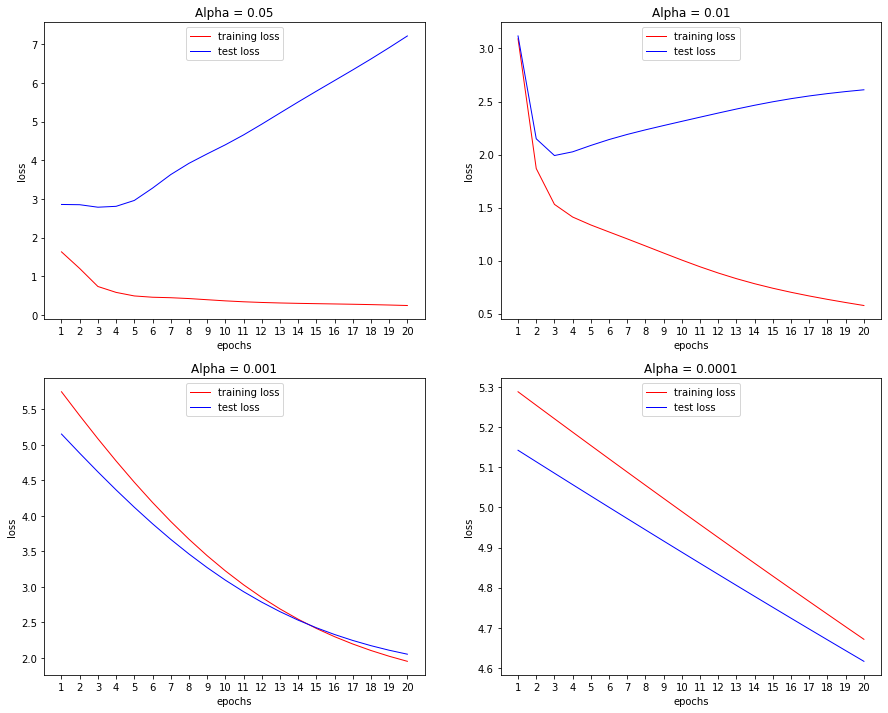

In [7]:
# train for 20 epochs and save the plot
epochs = 20
ep = list(range(1,21))
plt.figure(figsize=(15,12))
plt.subplot(2, 2, 1) 
P, Q, l_train,l_test = matrix_factorization(R, 5, 0.05, rng, epochs, ijs_train, ijs_test)
plt.plot(ep,l_train,color="r",label='training loss', linewidth=1)        
plt.plot(ep,l_test,color="b",label='test loss', linewidth=1)        
plt.xlabel('epochs')    
plt.ylabel('loss')   
plt.title("Alpha = 0.05")      
plt.legend(loc='upper center')          
my_x_ticks = np.arange(1, 21, 1)
plt.xticks(my_x_ticks)
plt.subplot(2, 2, 2) 
P, Q, l_train,l_test = matrix_factorization(R, 5, 0.01, rng, epochs, ijs_train, ijs_test)
plt.plot(ep,l_train,color="r",label='training loss', linewidth=1)        
plt.plot(ep,l_test,color="b",label='test loss', linewidth=1)        
plt.xlabel('epochs')    
plt.ylabel('loss')   
plt.title("Alpha = 0.01")      
plt.legend(loc='upper center')          
my_x_ticks = np.arange(1, 21, 1)
plt.xticks(my_x_ticks)
plt.subplot(2, 2, 3) 
P, Q, l_train,l_test = matrix_factorization(R, 5, 0.001, rng, epochs, ijs_train, ijs_test)
plt.plot(ep,l_train,color="r",label='training loss', linewidth=1)        
plt.plot(ep,l_test,color="b",label='test loss', linewidth=1)        
plt.xlabel('epochs')    
plt.ylabel('loss')   
plt.title("Alpha = 0.001")      
plt.legend(loc='upper center')          
my_x_ticks = np.arange(1, 21, 1)
plt.xticks(my_x_ticks)
plt.subplot(2, 2, 4) 
P, Q, l_train,l_test = matrix_factorization(R, 5, 0.0001, rng, epochs, ijs_train, ijs_test)
plt.plot(ep,l_train,color="r",label='training loss', linewidth=1)        
plt.plot(ep,l_test,color="b",label='test loss', linewidth=1)        
plt.xlabel('epochs')    
plt.ylabel('loss')   
plt.title("Alpha = 0.0001")      
plt.legend(loc='upper center')          
my_x_ticks = np.arange(1, 21, 1)
plt.xticks(my_x_ticks)
plt.savefig('./training20.png')
# plt.show()

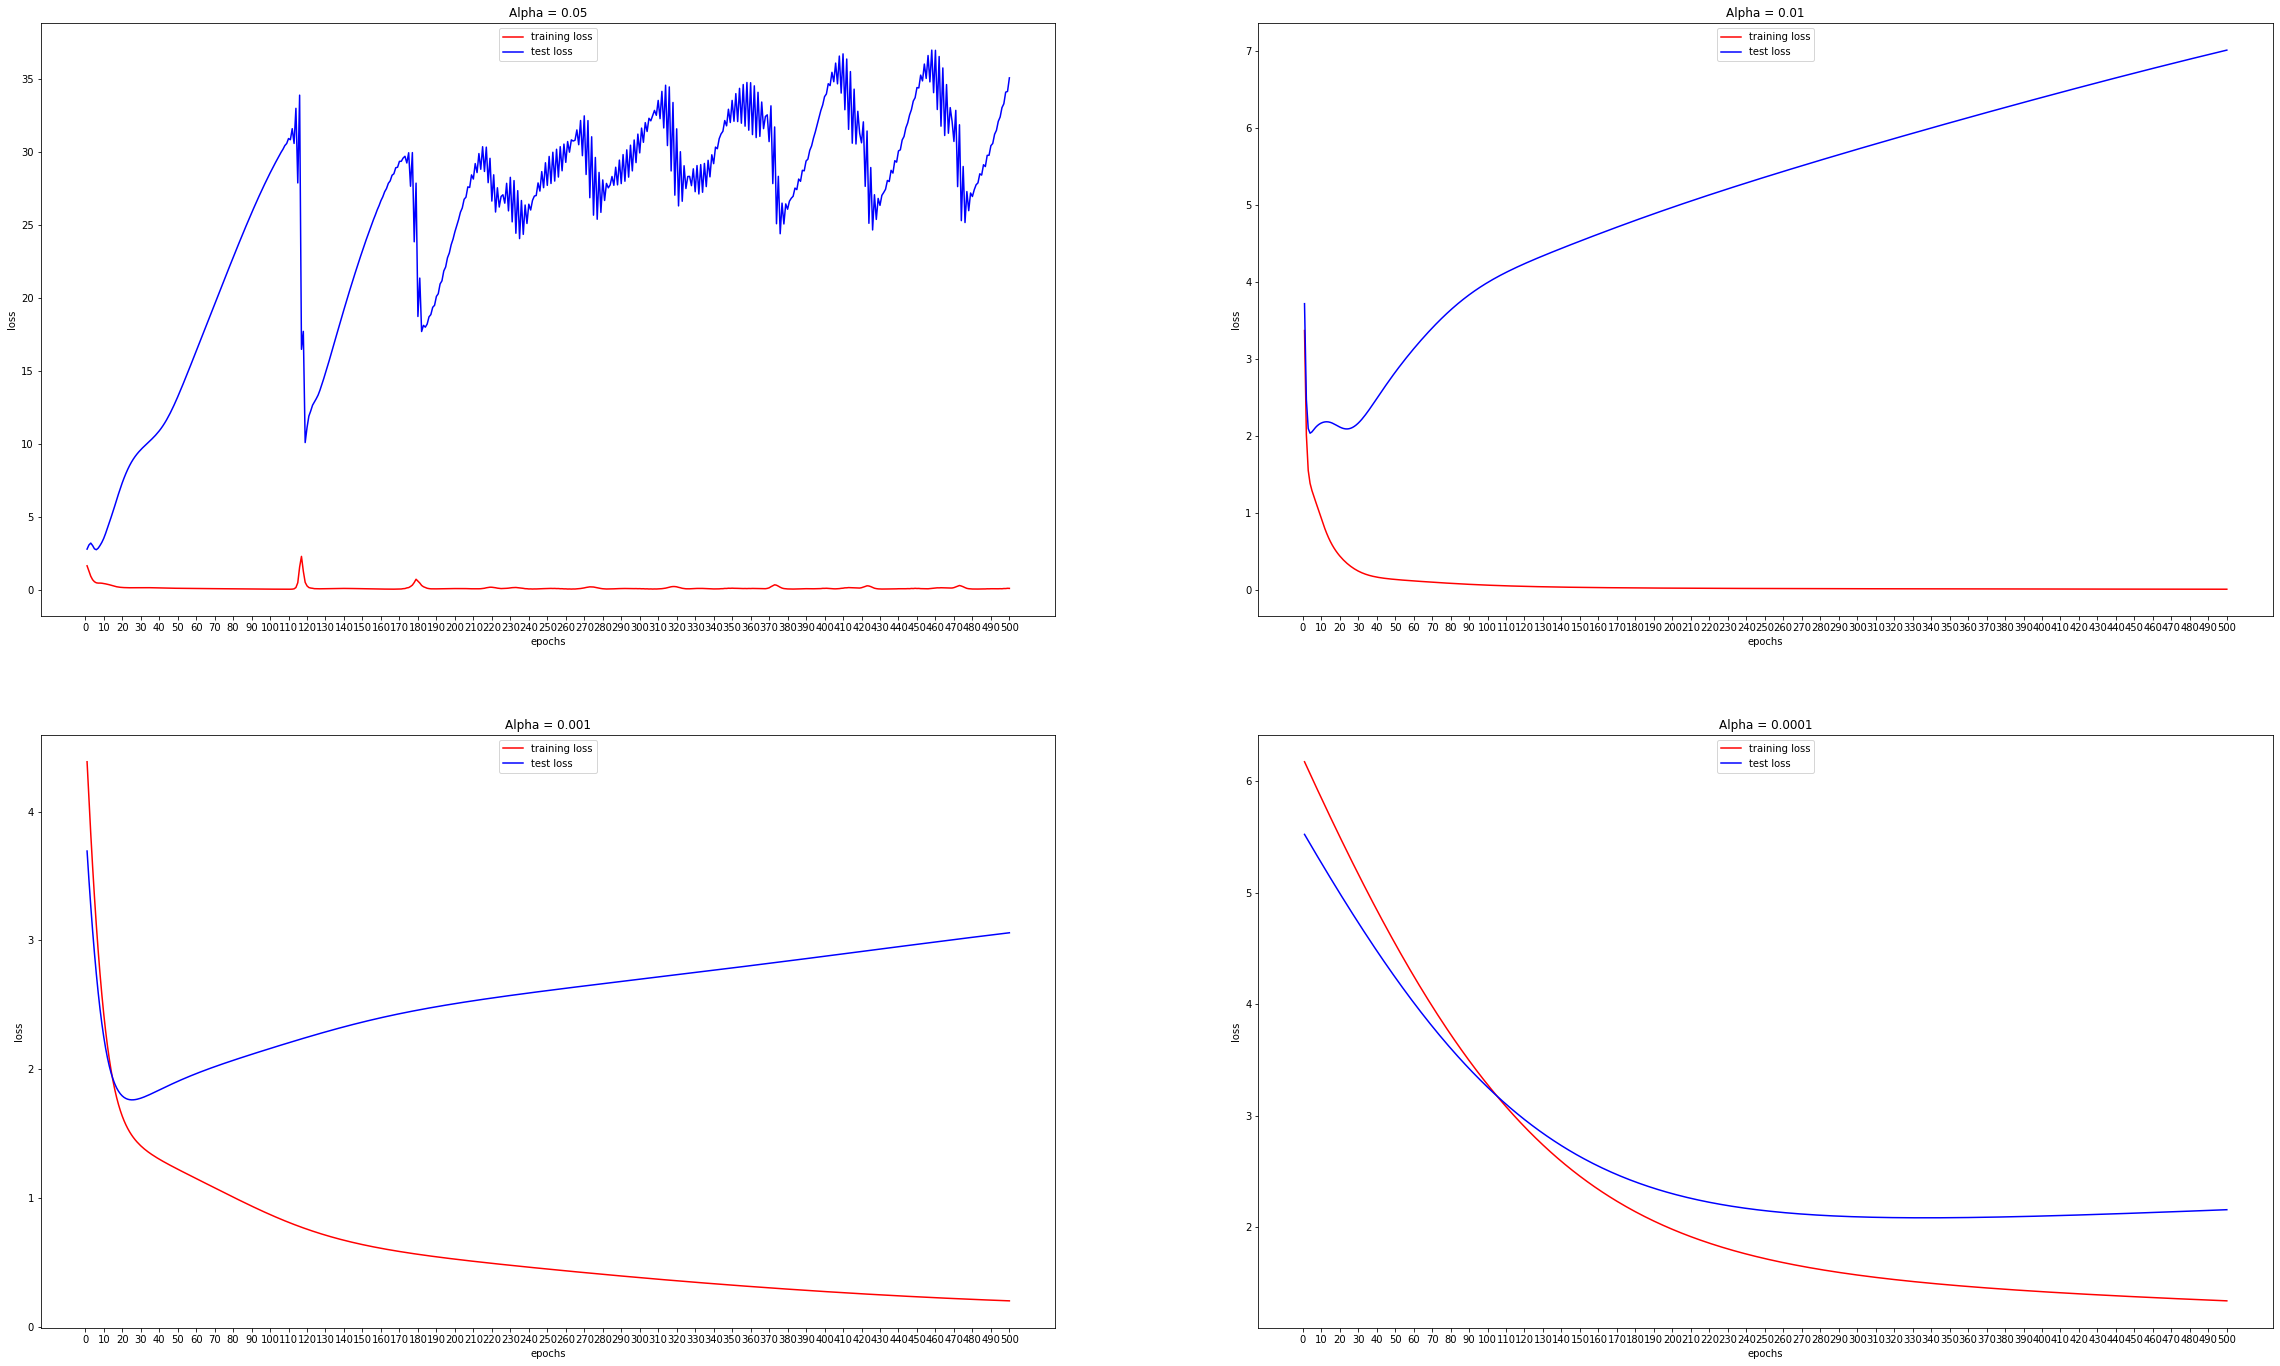

In [8]:
# train for 20 epochs and save the plot
epochs = 500
ep = list(range(1,501))
plt.figure(figsize=(40,24))
plt.subplot(2, 2, 1) 
P, Q, l_train,l_test = matrix_factorization(R, 5, 0.05, rng, epochs, ijs_train, ijs_test)
plt.plot(ep,l_train,color="r",label='training loss')        
plt.plot(ep,l_test,color="b",label='test loss')        
plt.xlabel('epochs')    
plt.ylabel('loss')   
plt.title("Alpha = 0.05")      
plt.legend(loc='upper center')          
my_x_ticks = np.arange(0, 501, 10)
plt.xticks(my_x_ticks)
plt.subplot(2, 2, 2) 
P, Q, l_train,l_test = matrix_factorization(R, 5, 0.01, rng, epochs, ijs_train, ijs_test)
plt.plot(ep,l_train,color="r",label='training loss')        
plt.plot(ep,l_test,color="b",label='test loss')        
plt.xlabel('epochs')    
plt.ylabel('loss')   
plt.title("Alpha = 0.01")      
plt.legend(loc='upper center')          
my_x_ticks = np.arange(0, 501, 10)
plt.xticks(my_x_ticks)
plt.subplot(2, 2, 3) 
P, Q, l_train,l_test = matrix_factorization(R, 5, 0.001, rng, epochs, ijs_train, ijs_test)
plt.plot(ep,l_train,color="r",label='training loss')        
plt.plot(ep,l_test,color="b",label='test loss')        
plt.xlabel('epochs')    
plt.ylabel('loss')   
plt.title("Alpha = 0.001")      
plt.legend(loc='upper center')          
my_x_ticks = np.arange(0, 501, 10)
plt.xticks(my_x_ticks)
plt.subplot(2, 2, 4) 
P, Q, l_train,l_test = matrix_factorization(R, 5, 0.0001, rng, epochs, ijs_train, ijs_test)
plt.plot(ep,l_train,color="r",label='training loss')        
plt.plot(ep,l_test,color="b",label='test loss')        
plt.xlabel('epochs')    
plt.ylabel('loss')   
plt.title("Alpha = 0.0001")      
plt.legend(loc='upper center')          
my_x_ticks = np.arange(0, 501, 10)
plt.xticks(my_x_ticks)
plt.savefig('./training500.png')
# plt.show()  

In [9]:
description20 = "For epoch equals to 20, we can find that: \n1) The training loss for different learning rate all decreases consistently, but test loss behaves differently.\n2) learing rate 0.05 and 0.01 are bad because gradient descent can result in learning a sub-optimal set of weights, thus increase rather than decrease the test loss.\n3) learning rate 0.0001 is not optimal, although the test loss continues to drop. This is because smaller learning rates require more training epochs, as changes made to the weights each update are small. \n4) learning rate 0.001 seems to be the best among four, because the test loss continues to drop and it is lowest."
description500 = "\n\nFor epoch equals to 500, we can find that: \n1) The performance of different learning rate is quite different.\n2) Learing rate 0.05 is too large as both loss oscilate, especially test loss. It is caused by weights that diverge.\n3) learning rate 0.01 and 0.001 are also bad because they behave in a similar way. Although both training and test loss drop at first, test loss quickly increase after 5 epochs of training. This is because large learning rate results in learning a sub-optimal set of weights, thus increase rather than decrease the test loss \n4) learning rate 0.0001 seems to be the best among four. Although test loss rises slightly after 200 epochs of training, it reaches the minimum. The rise might because the learning rate is still high for 500 epochs of training and gets stuck in learning sub-optimal weights."
# print(description20,description500)
print(description20+description500,  file=open('./training.txt', 'w'))

# Task 3: "Surprise" package (3 points)
The surprise package http://surpriselib.com/ is a python package for recommender systems.

For testing you can e.g. use the built-in "movie lens 100k" dataset.

## a) Apply to data (1.5)
Write a function `apply_surprise(data)` that splits the data into 80 percent training and 20 percent testing. It then calculate RMSE and MAE for the three recommender types BaselineOnly, NMF and KNNBasic. It returns a dictionary like so:
```python
{
    'BaselineOnly' : (RMSE, MAE, trained_instance),
    'NMF' : (RMSE, MAE, trained_instance),
    'KNNBasic' : (RMSE, MAE, trained_instance)
}
```
Where RMSE and MAE are calculated on the test set.

Result for the movie lens 100k dataset using `random_state=0` for the train-test split:
```python
{'BaselineOnly': (0.9550543124044737,
  0.7573425770736903,
  <surprise.prediction_algorithms.baseline_only.BaselineOnly at 0x1e46dd66e50>),
 'NMF': (0.9692337693760231,
  0.7636117736623521,
  <surprise.prediction_algorithms.matrix_factorization.NMF at 0x1e46dc86790>),
 'KNNBasic': (0.9872227056345668,
  0.7821631158458218,
  <surprise.prediction_algorithms.knns.KNNBasic at 0x1e46e008c70>)}
  ```

## b) Cross validate with the surprise package (1.5)

Write a function `cross_val_surprise(data)` that performs 5 fold cross validation and returns the mean an standard deviation of the RMSE and MAE.

```python
{
    'BaselineOnly' : (RMSE_mean, RMSE_std, MAE, MAE_std),
    'NMF' : (RMSE_mean, RMSE_std, MAE, MAE_std),
    'KNNBasic' : (RMSE_mean, RMSE_std, MAE, MAE_std)
}
```

Result for the movie lens 100k dataset using `cv=KFold(n_splits=5, random_state=0)`.
```python
{'BaselineOnly': (0.9439693435434332,
  0.005917617695892292,
  0.7483729454435822,
  0.004810636871680646),
 'NMF': (0.9639085178892854,
  0.003642645329612351,
  0.7574494428884382,
  0.0036830260508856336),
 'KNNBasic': (0.9797335044073868,
  0.00496152108148495,
  0.7736279266439918,
  0.004948889332343514)}
```

In [425]:
from surprise import NMF, KNNBasic, BaselineOnly
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy

data = Dataset.load_builtin('ml-100k')

def apply_surprise(data):
    algos = [BaselineOnly, NMF, KNNBasic]
    names = ['BaselineOnly', 'NMF', 'KNNBasic']
    result_dict={}
    # Code here
    # split the data into 0.8:0.2
    trainset, testset = train_test_split(data, test_size=0.2,random_state=0)
    print(trainset)
    for algo_class, name in zip(algos, names):
        # Code here
        algo = algo_class()
        algo.fit(trainset)
        predictions = algo.test(testset)
        RMSE = accuracy.rmse(predictions)
        MAE = accuracy.mae(predictions)
        instance = trainset
        result_dict[name] = (RMSE, MAE, instance)
    return result_dict

In [445]:
from surprise.model_selection import KFold
def cross_val_surprise(data):
    """
    np.std() 得到的结果是0， 参考答案不是0
    """
    algos = [BaselineOnly, NMF, KNNBasic]
    names = ['BaselineOnly', 'NMF', 'KNNBasic']
    result_dict={}
    for algo_class, name in zip(algos, names):
        # Code here
        cv_RMSE = []
        cv_MAE = []
        cv = KFold(n_splits=5, random_state=0)
        for trainset, testset in cv.split(data):
            algo = algo_class()
            algo.fit(trainset)
            predictions = algo.test(testset)
            RMSE = accuracy.rmse(predictions)
            cv_RMSE.append(RMSE)
            MAE = accuracy.mae(predictions)
            cv_MAE.append(MAE)
            result_dict[name] = (np.mean(RMSE), np.std(RMSE,dtype=np.float64), np.mean(MAE), np.std(MAE,dtype=np.float64))
    return result_dict

In [446]:
cross_val_surprise(data)

Estimating biases using als...
RMSE: 0.9447
MAE:  0.7491
Estimating biases using als...
RMSE: 0.9401
MAE:  0.7459
Estimating biases using als...
RMSE: 0.9383
MAE:  0.7437
Estimating biases using als...
RMSE: 0.9417
MAE:  0.7458
Estimating biases using als...
RMSE: 0.9551
MAE:  0.7573
RMSE: 0.9641
MAE:  0.7573
RMSE: 0.9624
MAE:  0.7554
RMSE: 0.9628
MAE:  0.7578
RMSE: 0.9628
MAE:  0.7556
RMSE: 0.9747
MAE:  0.7696
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9841
MAE:  0.7763
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9754
MAE:  0.7706
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9765
MAE:  0.7696
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9755
MAE:  0.7695
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9872
MAE:  0.7822


{'BaselineOnly': (0.9550543124044737, 0.0, 0.7573425770736903, 0.0),
 'NMF': (0.9747230281875404, 0.0, 0.7696187245632697, 0.0),
 'KNNBasic': (0.9872227056345668, 0.0, 0.7821631158458218, 0.0)}